In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # removes the warning messages from tensorflow

In [2]:
import wfdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.utils.class_weight import compute_class_weight
import pywt
import funcs
import plot_learning_callback
import f1_metric

In [3]:
# use gpu

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
path = "pickled/"
trainReadings = funcs.unpickler(path + 'train_readings.pkl')
trainDiagnostic = funcs.unpickler(path + 'train_diagnostic.pkl')
validateReadings = funcs.unpickler(path + 'validate_readings.pkl')
validateDiagnostic = funcs.unpickler(path + 'validate_diagnostic.pkl')
testReadings = funcs.unpickler(path + 'test_readings.pkl')
testDiagnostic = funcs.unpickler(path + 'test_diagnostic.pkl')

oneHotTrain = funcs.one_hot_encoder(trainDiagnostic, 2)
oneHotValidate = funcs.one_hot_encoder(validateDiagnostic, 2)
oneHotTest = funcs.one_hot_encoder(testDiagnostic, 2)

In [5]:
# data is imbalanced so we balance it

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(trainDiagnostic),
                                        y = trainDiagnostic                                                    
                                    )
class_weights = dict(zip(np.unique(trainDiagnostic), class_weights))

sigmoidLoss = tf.keras.losses.BinaryCrossentropy() # one output unit
softmaxLoss = tf.keras.losses.CategoricalCrossentropy() # two output units

In [6]:
scales = np.linspace(0.1, 4, 20) # scales to use for cwt

trainTransform = funcs.make_for_cnn(trainReadings, scales, 'mexh') # apply CWT to all training data
validateTransform = funcs.make_for_cnn(validateReadings, scales, 'mexh')
testTransform = funcs.make_for_cnn(testReadings, scales, 'mexh')

trainTransform.shape

(10977, 1000, 20)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, metrics, callbacks

In [29]:
inputShape = (32, 1000, len(scales))
kernelSize = 40 #how to determine this

In [49]:
convInputLayer = layers.Conv1D(
    filters=64, kernel_size=kernelSize, input_shape=inputShape[1:], data_format="channels_last")
convLayer = layers.Conv1D(
    filters=64, kernel_size=kernelSize)
batchNormLayer = layers.BatchNormalization(axis=1)
reLULayer = layers.ReLU()
maxPoolLayer = layers.MaxPooling1D(
    pool_size=kernelSize * 2, strides=None) # should the size of the pooling layer be the same as the kernel size

In [50]:
metrics=['accuracy', 
         tf.keras.metrics.Precision(name='precision'), 
         tf.keras.metrics.Recall(name='recall'),
         f1_metric.f1]

# Test out alternative architectures

In [56]:
# adding dropout layer to prevent overfitting

tf.random.set_seed(42)

inputDroppedPercent = 20 # during training, 20 percent of the inputs (to the dropout layer) are randomly dropped
dropoutLayer = layers.Dropout(inputDroppedPercent / 100)
sectionRepeat = 4

In [57]:
model = Sequential()

for i in range(sectionRepeat):
    model.add(convLayer)
    model.add(batchNormLayer)
    model.add(dropoutLayer)
    model.add(reLULayer)
    model.add(maxPoolLayer)

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [58]:
# create a checkpoint for the best val

currentDirectory = os.getcwd()
f1FileName = 'bestf1.hdf5' # model weights are stored in hdf5 file
f1File = os.path.join(currentDirectory, 'ckpt', f1FileName)

f1Checkpoint = callbacks.ModelCheckpoint(filepath=f1File, 
                                       save_weights_only=True, 
                                       monitor='f1',
                                       mode='max', #save when the f1 score is the highest
                                       save_best_only=True, 
                                      )

In [59]:
model.compile(
    optimizer='adam', loss=sigmoidLoss, 
 metrics=metrics)

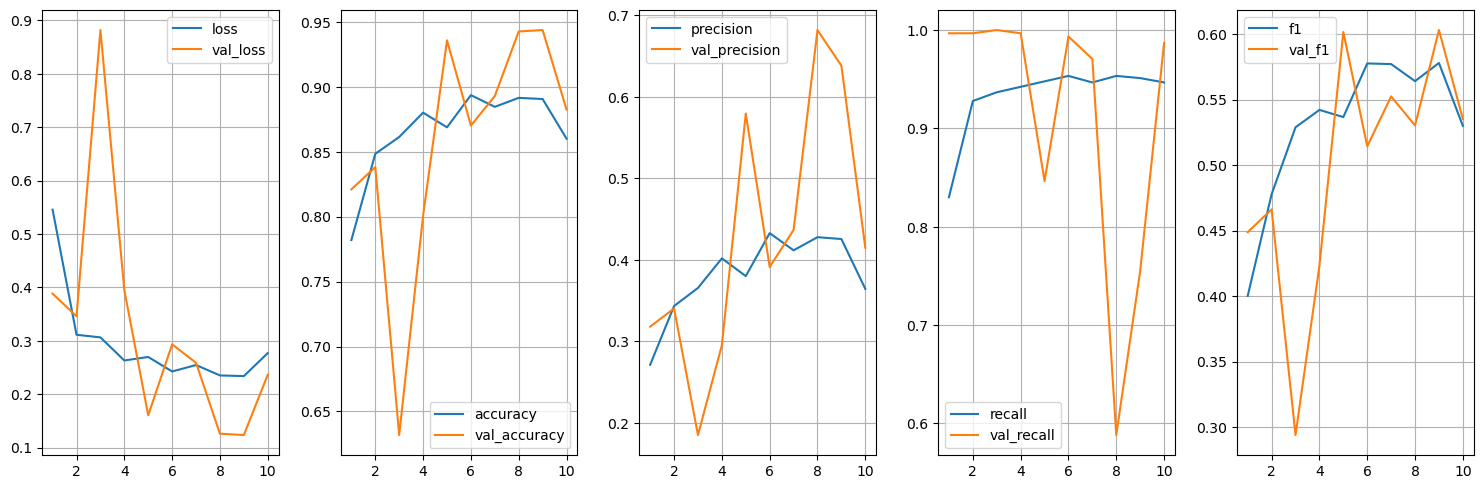

344/344 [==============================] - 23s 67ms/step - loss: 0.2770 - accuracy: 0.8601 - precision: 0.3644 - recall: 0.9467 - f1: 0.5300 - val_loss: 0.2364 - val_accuracy: 0.8825 - val_precision: 0.4148 - val_recall: 0.9869 - val_f1: 0.5353


In [60]:
history = model.fit(
    trainTransform, trainDiagnostic, 
    epochs=10, 
    class_weight=class_weights,
    validation_data=(validateTransform, validateDiagnostic), 
    callbacks=[plot_learning_callback.PlotLearning(), f1Checkpoint]
)

In [ ]:
funcs.graph_losses(history, "Loss")

In [ ]:
funcs.graph_losses(history, "Accuracy")

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(history.history['f1'])

In [ ]:
history.history.keys()

In [ ]:
funcs.evaluate_model(model.predict(testTransform), testDiagnostic)

In [ ]:
bestf1Model = tf.keras.models.clone_model(modelv2)

In [ ]:
bestf1Model.compile(
    optimizer='adam', loss=softmaxLoss, 
 metrics=metrics)

In [ ]:
bestf1Model.load_weights('ckpt/bestf1.hdf5')

In [ ]:
bestf1Model.evaluate(testTransform, oneHotTest)